# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from model import QNetwork

In [4]:
from collections import namedtuple, deque

In [5]:
## Hyperparameters

## For Experience Replay
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size


## For Fixed-Q Target
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network


GAMMA = 0.99            # discount factor for cumulative rewards
LR = 5e-4               # learning rate for our neural network

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Q-Network (Local and Target both having the same weights initially)
qnetwork_local = QNetwork(state_size=8, action_size=4, seed=0).to(device)
qnetwork_target = QNetwork(state_size=8, action_size=4, seed=0).to(device)
optimizer = optim.Adam(qnetwork_local.parameters(), lr=LR)

In [8]:
# Some utility and data variables
replay_memory = deque(maxlen=BUFFER_SIZE) 
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
t_step = 0

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [9]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
action_size = env.action_space.n

State shape:  (8,)
Number of actions:  4


###  Testing Environment and Agent

This is just for testing purpose. Skip to action item 3 to save time.

In [10]:
## Test: Environment 
state = env.reset()
print("State:")
print(state)

action = random.choice(np.arange(env.action_space.n))
print("Action:")
print(action)

State:
[-5.9156417e-04  1.4134574e+00 -5.9935719e-02  1.1277095e-01
  6.9228926e-04  1.3576316e-02  0.0000000e+00  0.0000000e+00]
Action:
2


In [11]:
# Test : Environment
state = env.reset()
for j in range(200):
    action = random.choice(np.arange(env.action_space.n))
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Code for running inference on Q Network

In [10]:
## one of the main core logic of DQN - To run INFERENCE on Q NETWORK
def epsilon_greedy(state, eps=0.):
    """Returns actions for given state as per current policy.

    Params
    ======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    qnetwork_local.eval()
    with torch.no_grad():
        action_values = qnetwork_local(state)
    qnetwork_local.train()

    # Epsilon-greedy action selection
    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(action_size))

### Testing Environment and Agent

This is just for testing purpose. Skip to action item 4 to save time.


In [14]:
## now watch the untrained agent - Runing inference on untrained Q Network
for i in range(3):
    state = env.reset()
    for j in range(200):
        action = epsilon_greedy(state, 0.10)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

In [11]:
## And now watch the trained agent - from previously trained and saved weights

# load the weights from file
qnetwork_local.load_state_dict(torch.load('checkpoint_dqn.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = epsilon_greedy(state, 0.10)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 4. Training code starts from here

In [12]:
## Utility function to randomly sample the expereinces tuples from memory
def sample(memory):
    """Randomly sample a batch of experiences from memory."""
    experiences = random.sample(memory, k=BATCH_SIZE)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, rewards, next_states, dones)

In [13]:
## Another utility function to implement Fixed Q-Target logic
def soft_update_Q_targets(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
## One of the main core logic of DQN - To TRAIN Q NETWORK
def train_Q_network(state, action, reward, next_state, done, total_step):    
    # Save experience in replay memory
    e = experience(state, action, reward, next_state, done)
    replay_memory.append(e)
    
    # Train Q_Network every UPDATE_EVERY time steps.
    #t_step = (t_step + 1) % UPDATE_EVERY
    if total_step % UPDATE_EVERY == 0:
        total_step = 0
        # If enough samples are available in memory, get random subset and train Q_Network
        # If BATCH_SIZE is zero, then there is no EXPERIENCE REPLAY used
        if len(replay_memory) > BATCH_SIZE:
            experiences = sample(replay_memory)
            states, actions, rewards, next_states, dones = experiences

            # Get max predicted Q values (for next states) from TARGET MODEL 
            #If TARGET MODEL is same as LOCAL Model, then no FIXED Q-TARGET used
            Q_targets_next = qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
            # Compute Q targets for current states 
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

            # Get expected Q values from LOCAL MODEL
            Q_expected = qnetwork_local(states).gather(1, actions)        
        
            # Compute loss
            loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()                 

            # ------------------- soft update target network ------------------- #
            soft_update_Q_targets(qnetwork_local, qnetwork_target, TAU)  

### 5. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: -115.77
Episode 200	Average Score: -36.703
Episode 300	Average Score: 54.803
Episode 400	Average Score: 181.53
Episode 414	Average Score: 200.41
Environment solved in 314 episodes!	Average Score: 200.41


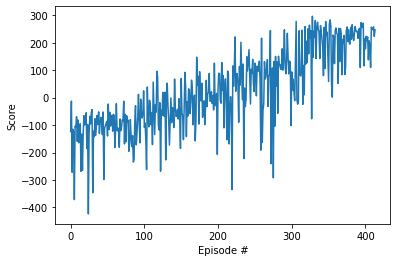

In [111]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    t_step = 0
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            t_step += 1
            action = epsilon_greedy(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            score += reward  # add reward to the current score   
            train_Q_network(state, action, reward, next_state, done, t_step)
            state = next_state
            
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(qnetwork_local.state_dict(), 'checkpoint_dqn.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [82]:
# load the weights from file
qnetwork_local.load_state_dict(torch.load('checkpoint_dqn.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = epsilon_greedy(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 7. Future Tasks

In this exercise, we have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue our learning, there are some future tasks:
- Amend the various hyperparameters and network architecture to see if we can get our agent to solve the environment faster.  
- We may also try some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 